# Customer Segmentation in Retail Industry

Customer segmentation aims dividing customers into subsets of customers. The customers in the same subsets are expected to have common behavioral patterns (such as inclination to buy a product). It is, then, easier to implement specific strategies to target them, like positioning a product to a different market segment. 

Segmentation can be carried out using behavioural features, such as purchase of products, geographic features, such as region and population, demographic features, such as age and gender.

Since the number of patterns and the patterns among customers are not known in advance, we use unsupervised learning.

In this course, we are going to use two approaches for customer segmentation:
    1. Clustering
    2. Mixture models

# Segmentation

In retail industry, products are categorized with respect to a product taxonomy. In fashion retailing, an example product taxonomy can be:

    - Men's wear
        - Pants
        - Shorts
        - Shirts
            - Casual
            - Business
        - Shoes
    - Women's wear
    - ...
    
In FMCG retailing, an example product taxonomy can be:
    - Fruits, Vegetables
        - Fruits
        - Vegetables
        - Organic products
    - Detergent, Cleaners
        - Laundry
        - Dish washing
        - Bathing
        - Home cleaning
    - Red meat
    - ...
    
## Our Aim

We aim to create customer segments based on their purchases from different product categories. In other words, we wish to create segments such as:

* Customers that buy mostly fruits and red meat
* Customers who mostly buy detergents ...
    
## Loading data

We use transaction data for customers in 6 product categories. We try and identify customer patterns based on category purchases. A customer segmentation based on RFM (Recency/Frequency/Monetary) values is carried on by Chen et al. in "Data Mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining". Dataset used in the study can be accessed at:

https://archive.ics.uci.edu/ml/datasets/Online+Retail


First, we load the necessary packages and examine data:


In [1]:
print(__doc__)
%matplotlib inline
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GMM
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
import pandas as pd 
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
sns.set_style("whitegrid")

df_train = pd.read_csv('Transactions_2015.csv')

print(df_train.head())
print(df_train.describe())

Automatically created module for IPython interactive environment
   Customer_ID  Category_1  Category_2  Category_3  Category_4  Category_5  \
0      1007727      165.97      180.84      145.85       20.20       16.52   
1      1013989      129.20      189.21       98.14        1.05        1.39   
2      1014544      126.41      153.14         NaN       74.03      106.53   
3      1022560      150.60      259.20       96.72       28.28       21.34   
4      1026878      215.30       70.25      368.51       44.02       39.03   

   Category_6  
0         NaN  
1        0.24  
2         NaN  
3         NaN  
4         NaN  
        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.500000e+04  24840.000000  24397.000000  20006.000000  24192.000000   
mean   5.035996e+07    201.542572    273.615216    206.641346     44.794671   
std    2.857235e+07    206.348262    649.180535    262.600508     58.728076   
min    1.007727e+06     41.930000     22.310000   -213

C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


We can see that there are several cells with value NaN. This is a transaction data, so we can replace those values with 0. Let us use **fillna** function from pandas.

In [2]:
df_train.fillna(0,inplace = True)
#df_test.fillna(0,inplace = True)

print(df_train.head())
print(df_train.describe())

   Customer_ID  Category_1  Category_2  Category_3  Category_4  Category_5  \
0      1007727      165.97      180.84      145.85       20.20       16.52   
1      1013989      129.20      189.21       98.14        1.05        1.39   
2      1014544      126.41      153.14        0.00       74.03      106.53   
3      1022560      150.60      259.20       96.72       28.28       21.34   
4      1026878      215.30       70.25      368.51       44.02       39.03   

   Category_6  
0        0.00  
1        0.24  
2        0.00  
3        0.00  
4        0.00  
        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.500000e+04  25000.000000  25000.000000  25000.000000  25000.000000   
mean   5.035996e+07    200.252700    267.015617    165.362671     43.346907   
std    2.857235e+07    206.313828    642.675817    249.016958     58.311832   
min    1.007727e+06      0.000000      0.000000   -213.380000      0.000000   
25%    2.554748e+07    139.057500     63

It looks better now. However, there are some people spending more than 10000 on some product category. It can be that they are not regular customers but have some special property. They can be companies using the retailer's service. There are people who spent negative amounts, likely to be a mistake or return transactions. Let us see how many people have negative spendings per category.

In [3]:
negative_cells = df_train<0
print(negative_cells.sum())

Customer_ID    0
Category_1     0
Category_2     0
Category_3     8
Category_4     0
Category_5     0
Category_6     2
dtype: int64


It looks like there a few observations with negative values. We can just delete them.

In [4]:
df_train = df_train[negative_cells.sum(axis=1) < 1]
np.shape(df_train)

(24990, 7)

Let us find total spendings of customers and find outlier values. For this purpose, we use describe() function of pandas and boxplot.

0    529.38
1    419.23
2    460.11
3    556.14
4    737.11
dtype: float64
count    24990.000000
mean       739.844055
std        992.083641
min         25.030000
25%        350.267500
50%        563.540000
75%        773.285000
max      29165.580000
dtype: float64


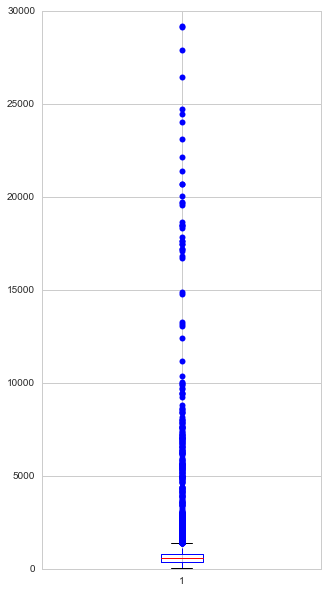

In [5]:
#df_sum = np.sum(df_train[['Category_' + str(i) for i in [1,2,3,4,5,6]]], axis=1)

df_sum = df_train[['Category_' + str(i) for i in [1,2,3,4,5,6]]].sum(axis=1)
print(df_sum.head())

print(df_sum.describe())
# basic plot


plt.figure(figsize=(5,10))
plt.boxplot(x=df_sum.values, sym='ko')
plt.show()

Now let us print some critical values and decide how to eliminate outliers. Only few people spend more tham 20000 TRY for example. We can delete these customers to obtain a better picture of the customers that we want to analyze. In some firms these customers are specially followed, so they might also be omitted from our data.

In [6]:
print(df_sum.min())
print(np.percentile(df_sum, 1))
print(np.percentile(df_sum, 5))
print(np.percentile(df_sum, 10))
print(np.percentile(df_sum, 25))
print(np.percentile(df_sum, 50))
print(np.percentile(df_sum, 75))
print(np.percentile(df_sum, 90))
print(np.percentile(df_sum, 95))
print(np.percentile(df_sum, 99))
print(df_sum.max())


25.03
191.0256
231.7345
253.369
350.2675
563.54
773.285
1509.196
1958.8995
2732.7317
29165.58


Maximum amount is 29000 TRY but we can see that 99% of customers spend less than 2732 TRY. We can eliminate these customers.

        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.474000e+04  24740.000000  24740.000000  24740.000000  24740.000000   
mean   5.035127e+07    185.061174    238.808747    150.784874     40.060982   
std    2.857101e+07     95.982992    377.869486    134.756991     34.824503   
min    1.007727e+06      0.000000      0.000000      0.000000      0.000000   
25%    2.552414e+07    138.657500     63.510000     26.617500     10.050000   
50%    5.038503e+07    168.670000    102.615000    138.830000     29.470000   
75%    7.497713e+07    205.755000    180.620000    245.750000     65.770000   
max    9.999723e+07   1891.280000   2096.040000    645.020000    178.850000   

        Category_5    Category_6           sum  
count  24740.00000  24740.000000  24740.000000  
mean      40.14716     18.624725    673.487662  
std       35.08454     34.575839    479.860914  
min        0.00000      0.000000     25.030000  
25%       10.05000      0.000000    346.622

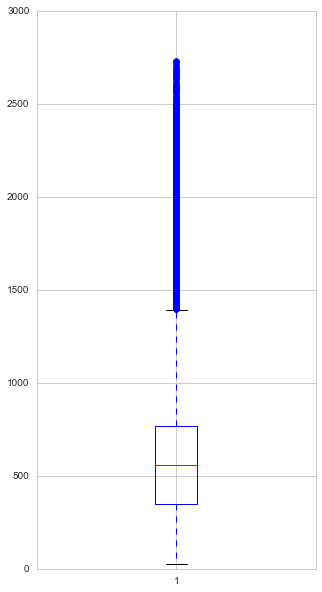

In [7]:
df_train['sum'] = df_sum

df_train = df_train[df_train['sum'] <= np.percentile(df_train['sum'], 99)]
df_train = df_train[df_train['sum'] >0]

print(df_train.describe())
plt.figure(figsize=(5,10))
plt.boxplot(df_train['sum'].values, sym='ko')
plt.show()

We eliminated more than 100 customers and now we have a clearer picture. We create a dataframe for the analysis and draw a correlation heat map.

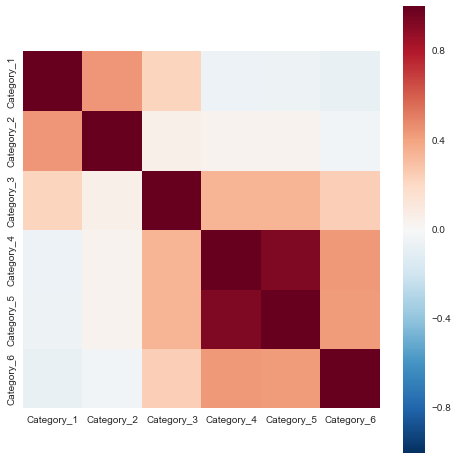

In [8]:
col_cat = [ u'Category_1', u'Category_2', u'Category_3', u'Category_4', u'Category_5', u'Category_6']
#col_mon = [ u'last_amo_6', u'last_amo_5', u'last_amo_4', u'last_amo_3', u'last_amo_2', u'last_amo_1']

df_train_cat = df_train[col_cat]
#df_train_mon = df_train[col_mon]

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()

Now that we have carried our preliminary analysis of data, it it time to discover the product categories and discuss our findings.

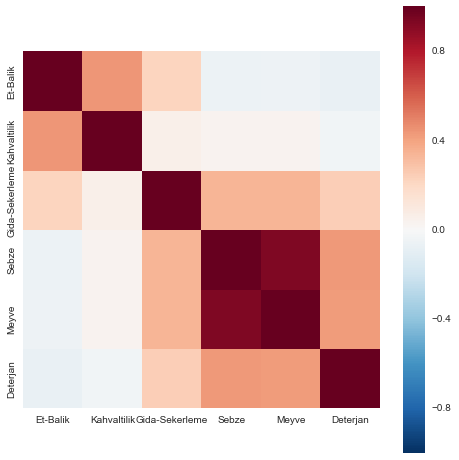

C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


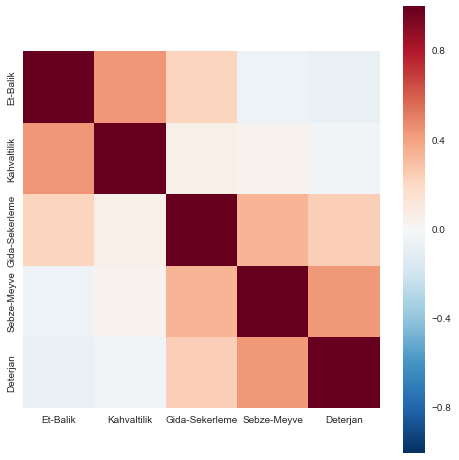

In [9]:
df_train_cat.columns = ['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme', 'Sebze', 'Meyve', 'Deterjan']

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()

df_train_cat['Sebze-Meyve'] = df_train_cat['Sebze'] + df_train_cat['Meyve']

df_train_cat.drop(['Sebze', 'Meyve'], axis=1, inplace=True)
df_train_cat = df_train_cat[['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme','Sebze-Meyve',  'Deterjan']]

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()


## Clustering 

We have already seen KMeans module, now let us apply our previous knowledge. You should also determine the number of clusters based on your intuition. 5 clusters can be a good starting number based on the number of product categories.

After using KMeans algorithm, we would like to see the cluster centers and try and interpret the results.

In [10]:
kmeans = KMeans(n_clusters = 5, n_init=10, random_state=0)
kmeans.fit(df_train_cat)

df_centers = pd.DataFrame(kmeans.cluster_centers_)
df_centers.columns = df_train_cat.columns

print(df_centers)

     Et-Balik  Kahvaltilik  Gida-Sekerleme  Sebze-Meyve   Deterjan
0  164.032797   113.294131       38.323959    37.977312   5.603671
1  338.040060  1454.567627      188.394030    93.384112  16.647933
2  129.882902   102.015231      201.791654   164.934707  46.289465
3  263.207420  1062.910504      149.413634    75.188495  12.184629
4  232.903399   100.562231      351.588003    80.322884  20.088991


It is not very easy to interpret the results in a table. Do we really measure patterns? What are these patterns? Let us visualize the clusters.

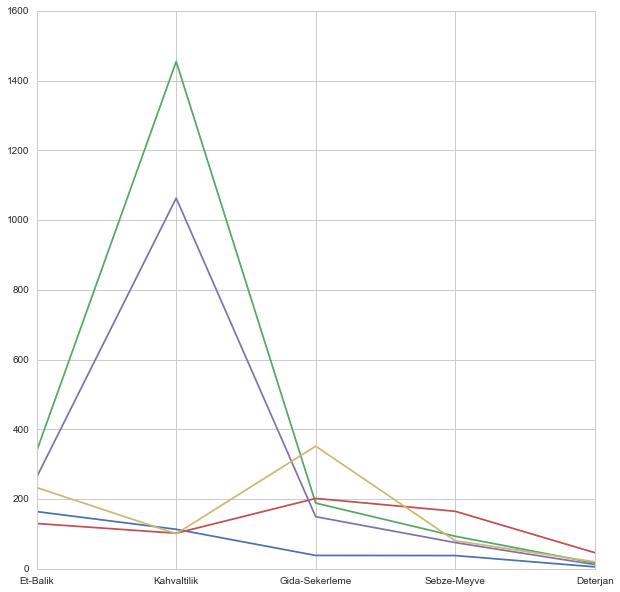

In [11]:
plt.figure(figsize=(10,10))
plt.plot(df_centers.transpose().values)
plt.xticks(np.arange(5), df_train_cat.columns)
plt.show()

The results suggest that customers differ in their spendings but not really in their spending patterns. However, we are not really looking for such an information. We aim to determine customer clusters based on the way they spend money. Two customers who prefer red meat should be in the same cluster regardless of the amount that they spend. In order to do that we should transform data. How??

   Et-Balik  Kahvaltilik  Gida-Sekerleme  Sebze-Meyve  Deterjan
0  0.160246     0.701089        0.084443     0.046552  0.007670
1  0.207220     0.172906        0.248776     0.304200  0.066897
2  0.635277     0.194597        0.081734     0.076415  0.011977
3  0.290827     0.128515        0.448797     0.106785  0.025077
4  0.338824     0.446811        0.147727     0.054762  0.011877


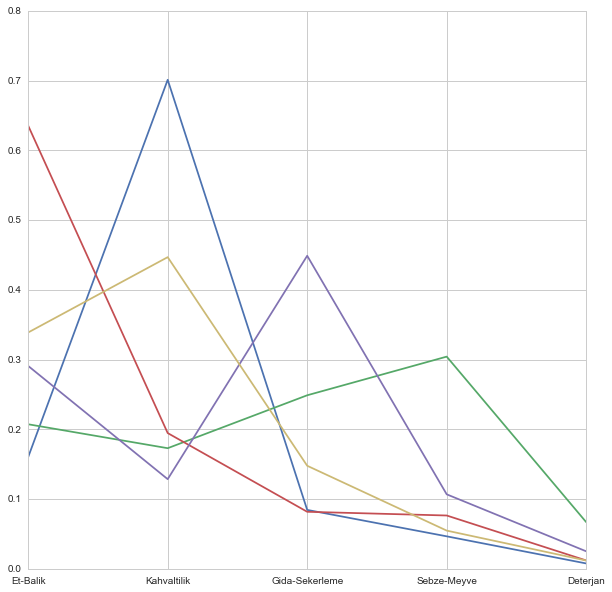

[0 1 2 3 4]
[2997 5690 6436 5747 3870]


'\nkmeans = KMeans(n_clusters=10)\n\nkmeans.fit(df_train_cat_pct)\ndf_centers = pd.DataFrame(kmeans.cluster_centers_)\ndf_centers.columns = df_train_cat_pct.columns\n\nprint(df_centers)\n\n\nplt.figure(figsize=(10,10))\nplt.plot(df_centers.transpose().values)\nplt.xticks(np.arange(5), df_train_cat.columns)\nplt.show()\n\n\na,b = np.unique(kmeans.labels_, return_counts=True)\n\nprint(a)\nprint(b)\n'

In [12]:
df_train_cat_pct = df_train_cat.div(df_train_cat.sum(axis=1), axis=0)

kmeans = KMeans(n_clusters=5, n_init = 10, random_state=0)

kmeans.fit(df_train_cat_pct)
df_centers = pd.DataFrame(kmeans.cluster_centers_)
df_centers.columns = df_train_cat_pct.columns

print(df_centers)

plt.figure(figsize=(10,10))
plt.plot(df_centers.transpose().values)
plt.xticks(np.arange(5), df_train_cat.columns)
plt.show()


a,b = np.unique(kmeans.labels_, return_counts=True)

print(a)
print(b)



    
    
"""
kmeans = KMeans(n_clusters=10)

kmeans.fit(df_train_cat_pct)
df_centers = pd.DataFrame(kmeans.cluster_centers_)
df_centers.columns = df_train_cat_pct.columns

print(df_centers)


plt.figure(figsize=(10,10))
plt.plot(df_centers.transpose().values)
plt.xticks(np.arange(5), df_train_cat.columns)
plt.show()


a,b = np.unique(kmeans.labels_, return_counts=True)

print(a)
print(b)
"""

Now customer patterns look different and closer to what we want. Is our clustering a success?

# Parallel Plot Visualization

We can see the success of our clusters by using parallel plot. In parallel plot, each customer corresponds to a line. We plot how their purchases are distributed (in terms of percentages) with respect to various categories. Let us draw 2 pictures, with respect to amount and with respect to percentages for clusters 0 and 1.

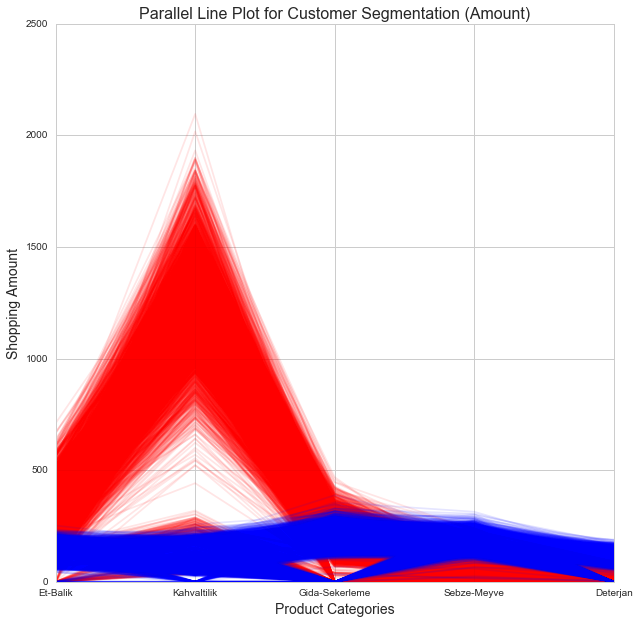

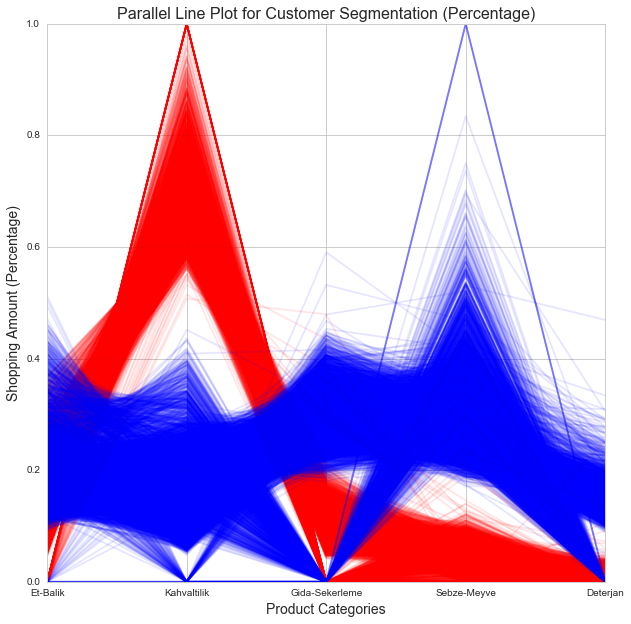

'\n#This is to plot all five clusters in a single figure\ndf0 = df_train_cat[kmeans.labels_ == 0]\ndf1 = df_train_cat[kmeans.labels_ == 1]\ndf2 = df_train_cat[kmeans.labels_ == 2]\ndf3 = df_train_cat[kmeans.labels_ == 3]\ndf4 = df_train_cat[kmeans.labels_ == 4]\n\nfig = plt.figure(figsize=(10, 10))\ndf0 = np.asarray(df0.transpose())\ndf1 = np.asarray(df1.transpose())\ndf2 = np.asarray(df2.transpose())\ndf3 = np.asarray(df3.transpose())\ndf4 = np.asarray(df4.transpose())\nplt.plot(df0, color="blue", alpha=0.1)\nplt.plot(df1, color="red", alpha=0.1)\nplt.plot(df2, color="green", alpha=0.1)\nplt.plot(df3, color="orange", alpha=0.1)\nplt.plot(df4, color="purple", alpha=0.1)\n\nx_range = range(0, ncols)\nplt.xlabel("Product Categories", fontsize = 14)\nplt.ylabel("Percentage of Shopping", fontsize = 14)\n\nplt.xticks(x_range, x_ticks)\nplt.title(\'Parallel Line Plot for Customer Segmentation\', fontsize=16)\nplt.show()\n'

In [13]:
x_ticks = df_train_cat.columns

ncols = 5 


df0 = df_train_cat[kmeans.labels_ == 0]
df1 = df_train_cat[kmeans.labels_ == 1]
fig = plt.figure(figsize=(10, 10))
df0 = np.asarray(df0.transpose())
df1 = np.asarray(df1.transpose())

plt.plot(df0, color="red", alpha=0.1)
plt.plot(df1, color="blue", alpha=0.1)
x_range = range(0, ncols)
plt.xlabel("Product Categories", fontsize = 14)
plt.ylabel("Shopping Amount", fontsize = 14)

plt.xticks(x_range, x_ticks)
plt.title('Parallel Line Plot for Customer Segmentation (Amount)', fontsize=16)
plt.show()


df0 = df_train_cat_pct[kmeans.labels_ == 0]
df1 = df_train_cat_pct[kmeans.labels_ == 1]
fig = plt.figure(figsize=(10, 10))
df0 = np.asarray(df0.transpose())
df1 = np.asarray(df1.transpose())

plt.plot(df0, color="red", alpha=0.1)
plt.plot(df1, color="blue", alpha=0.1)
x_range = range(0, ncols)
plt.xlabel("Product Categories", fontsize = 14)
plt.ylabel("Shopping Amount (Percentage)", fontsize = 14)

plt.xticks(x_range, x_ticks)
plt.title('Parallel Line Plot for Customer Segmentation (Percentage)', fontsize=16)
plt.show()
 
"""
#This is to plot all five clusters in a single figure
df0 = df_train_cat[kmeans.labels_ == 0]
df1 = df_train_cat[kmeans.labels_ == 1]
df2 = df_train_cat[kmeans.labels_ == 2]
df3 = df_train_cat[kmeans.labels_ == 3]
df4 = df_train_cat[kmeans.labels_ == 4]

fig = plt.figure(figsize=(10, 10))
df0 = np.asarray(df0.transpose())
df1 = np.asarray(df1.transpose())
df2 = np.asarray(df2.transpose())
df3 = np.asarray(df3.transpose())
df4 = np.asarray(df4.transpose())
plt.plot(df0, color="blue", alpha=0.1)
plt.plot(df1, color="red", alpha=0.1)
plt.plot(df2, color="green", alpha=0.1)
plt.plot(df3, color="orange", alpha=0.1)
plt.plot(df4, color="purple", alpha=0.1)

x_range = range(0, ncols)
plt.xlabel("Product Categories", fontsize = 14)
plt.ylabel("Percentage of Shopping", fontsize = 14)

plt.xticks(x_range, x_ticks)
plt.title('Parallel Line Plot for Customer Segmentation', fontsize=16)
plt.show()
"""

Now, we draw the same plot for every cluster pair, this time only using percentages.

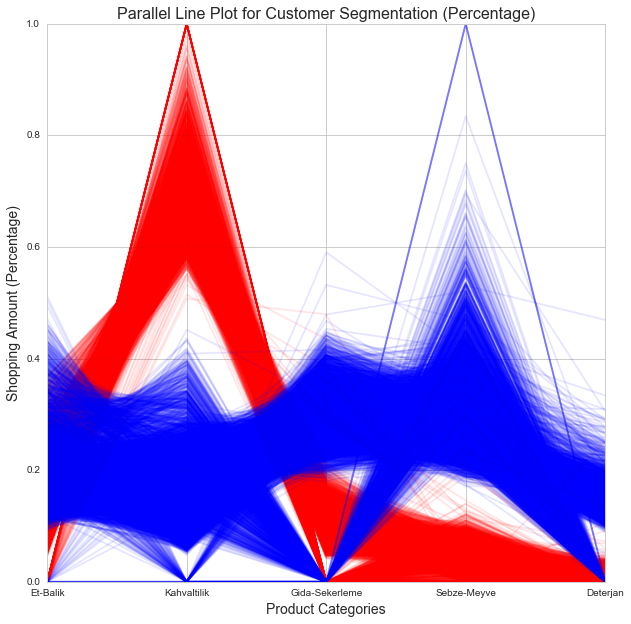

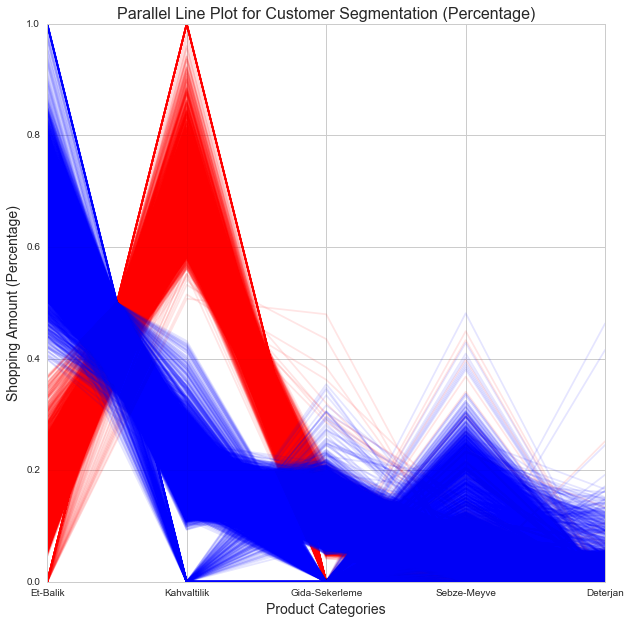

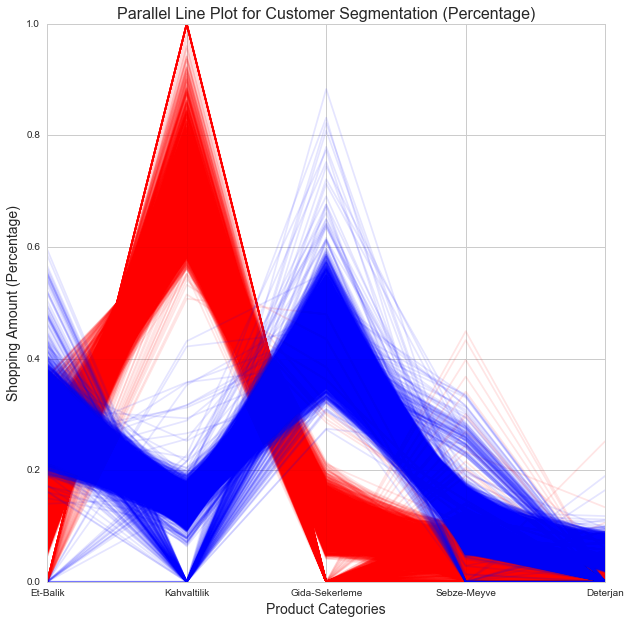

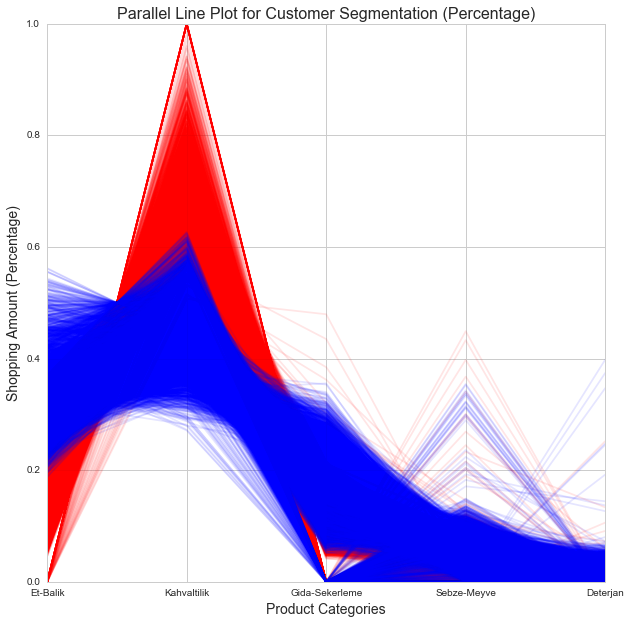

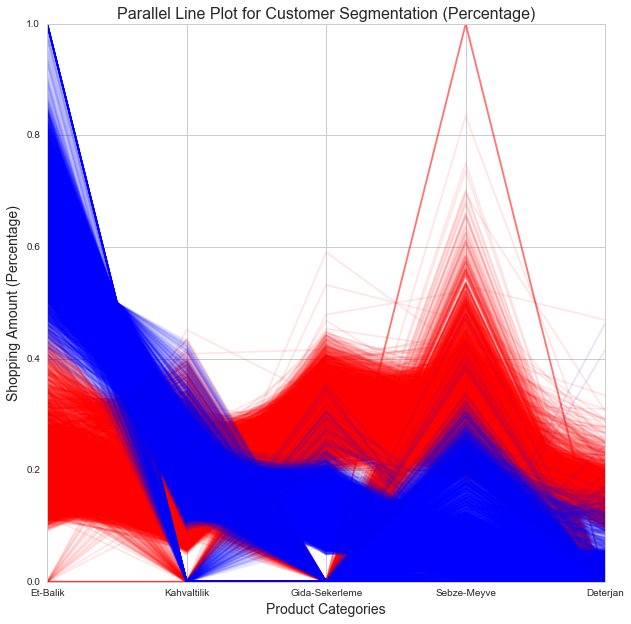

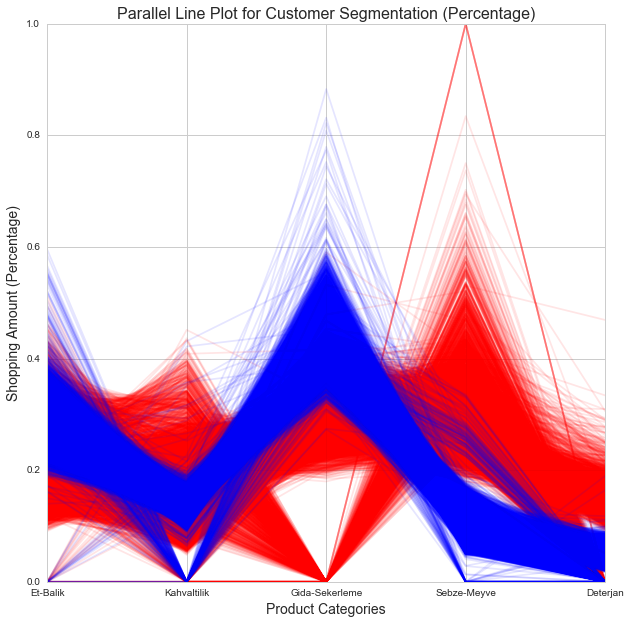

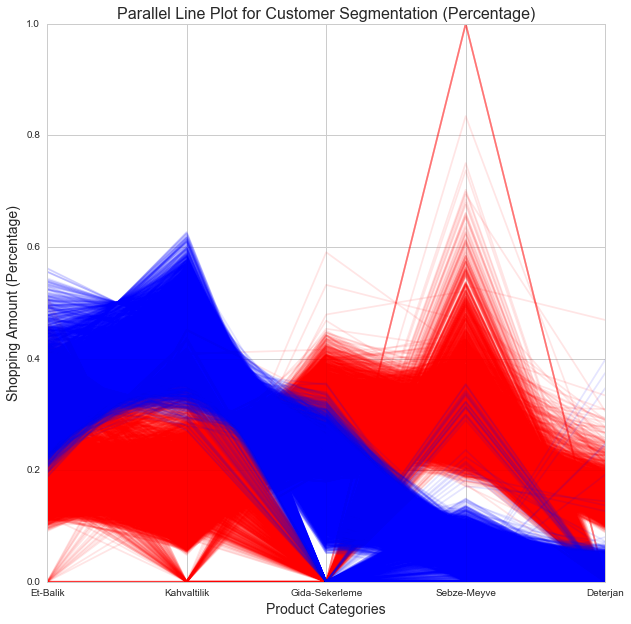

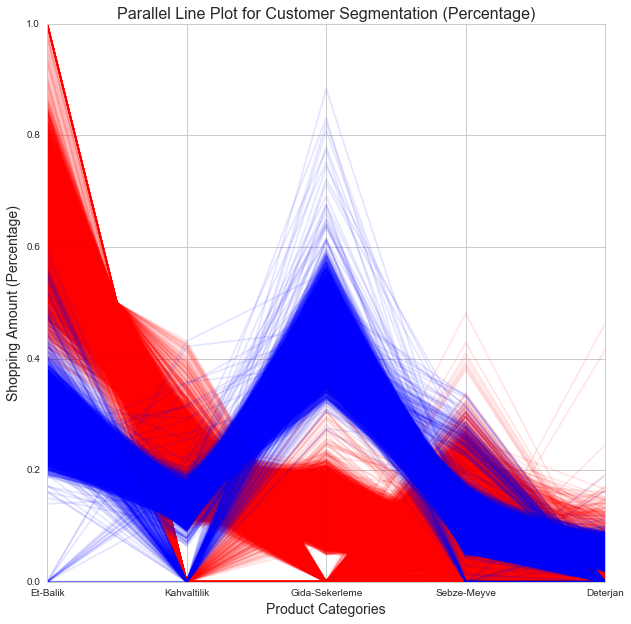

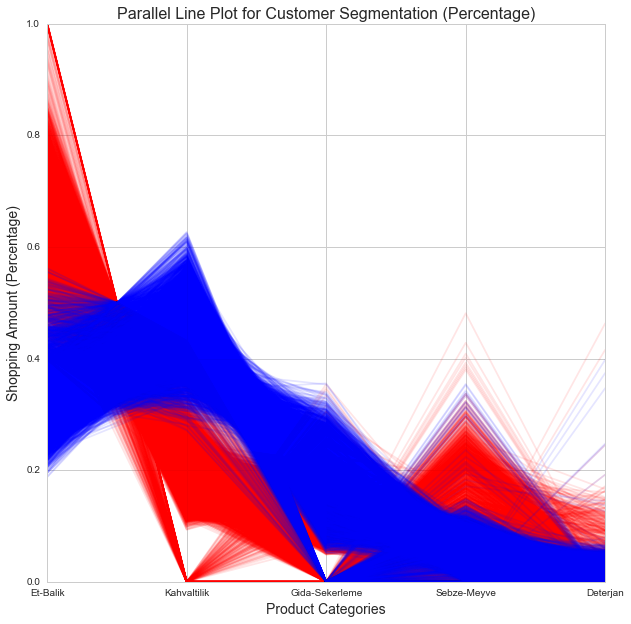

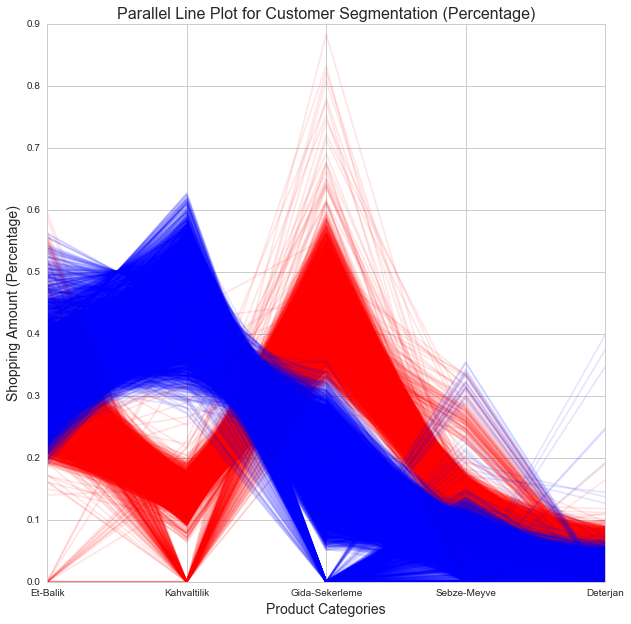

In [14]:

for i in range(5):
    for j in range(i+1,5):
        df0 = df_train_cat_pct[kmeans.labels_ == i]
        df1 = df_train_cat_pct[kmeans.labels_ == j]
        fig = plt.figure(figsize=(10, 10))
        df0 = np.asarray(df0.transpose())
        df1 = np.asarray(df1.transpose())

        plt.plot(df0, color="red", alpha=0.1)
        plt.plot(df1, color="blue", alpha=0.1)
        x_range = range(0, ncols)
        plt.xlabel("Product Categories", fontsize = 14)
        plt.ylabel("Shopping Amount (Percentage)", fontsize = 14)

        plt.xticks(x_range, x_ticks)
        plt.title('Parallel Line Plot for Customer Segmentation (Percentage)', fontsize=16)
        plt.show()

After obtaining customer segments, we can try and see which segments are more important, for that we use pie chart and compare the number of customers in a cluster and the total spending of the same customers.

   label     sum
0      4  533.38
1      4  423.23
2      1  461.11
3      4  560.14
4      3  740.11
              sum
label            
0      5076790.48
1      3562037.44
2      1917820.07
3      4206357.24
4      1950362.54


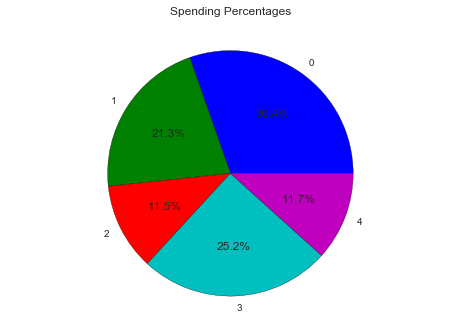

label
0    5076790.48
1    3562037.44
2    1917820.07
3    4206357.24
4    1950362.54
Name: sum, dtype: float64
[2997 5690 6436 5747 3870]


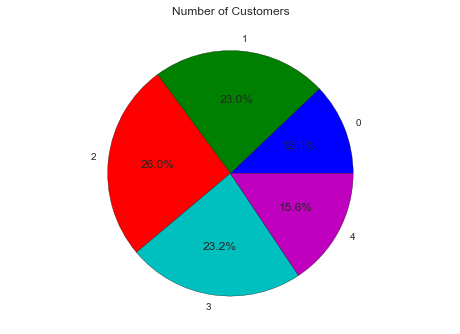

In [15]:
df_train_cat['label'] = kmeans.predict(df_train_cat_pct)
df = pd.DataFrame(df_train_cat['label'])
df['sum'] = df_train_cat.sum(axis=1)

print(df.head())
var = df.groupby(['label']).sum().stack()
temp=var.unstack()
print(temp)
x_list = temp['sum']
label_list = temp.index
plt.axis("equal") #The pie chart is oval by default. To make it a circle use pyplot.axis("equal")
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%") 
plt.title("Spending Percentages")
plt.show()

print x_list

labels, label_counts = np.unique(df['label'].values, return_counts=True) 

print label_counts

plt.axis("equal") #The pie chart is oval by default. To make it a circle use pyplot.axis("equal")
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(label_counts,labels=labels,autopct="%1.1f%%") 
plt.title("Number of Customers")
plt.show()

Cluster 0 contains 12% of customers, but they represent more than 30% of sales. In contrast customers in cluster 2 (26% of all customers) represent only 11% of all sales. So the customers in cluster 0 have high value for retailer and customers in cluster 2 represent customers that have lower value. 

# References

Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012.

## Silhouette scores (Optional)

Silhouette scores measure the similarity of observations in and between classes. 

It is calculated using the mean between-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficent is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

If there is a cluster below the silhouette score or if the size of clusters differ significantly you can think of changing the number of clusters. In addition to that if there are many samples with negative score, they are not assigned to the correct clusters.

('For n_clusters =', 5, 'The average silhouette_score is :', 0.48293147466922015)


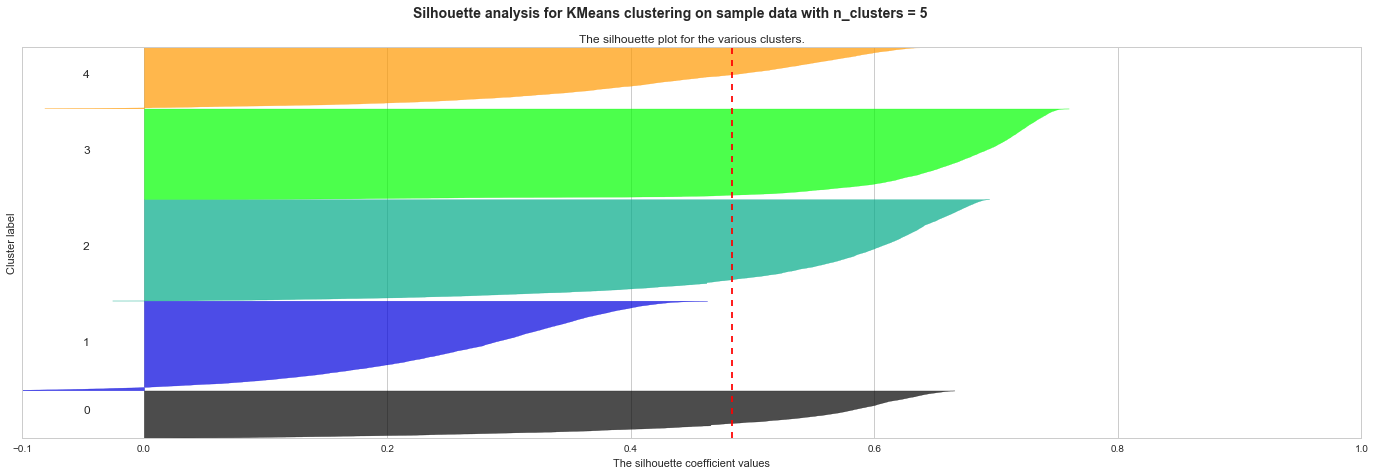

In [16]:

range_n_clusters = [5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(24, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_train_cat_pct) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df_train_cat_pct)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_train_cat_pct, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_train_cat_pct, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    

('For n_clusters =', 6, 'The average silhouette_score is :', 0.50761261386852818)


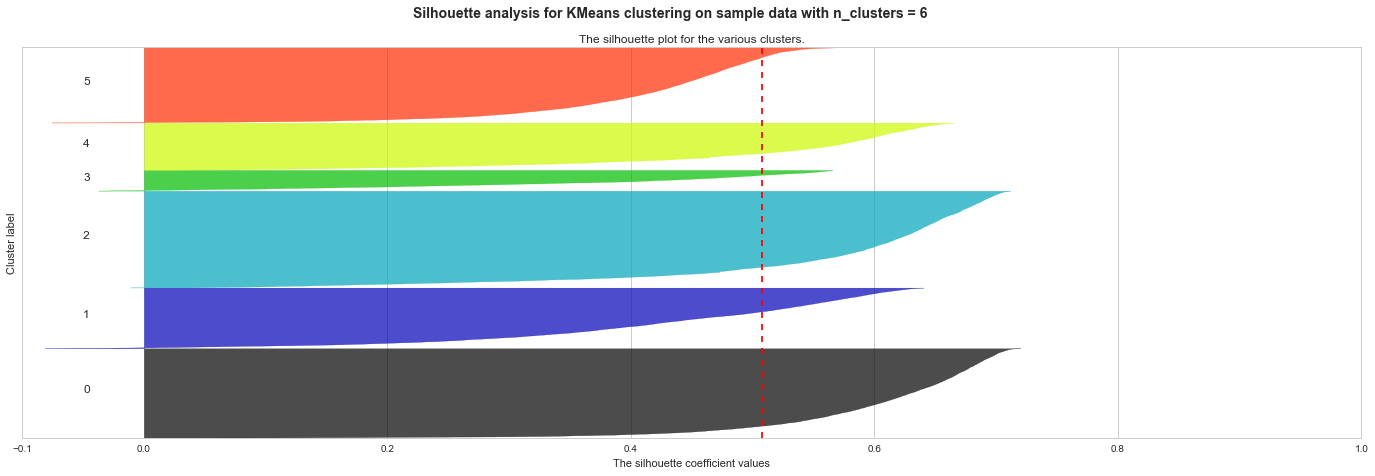

In [17]:

range_n_clusters = [6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(24, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_train_cat_pct) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df_train_cat_pct)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_train_cat_pct, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_train_cat_pct, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    